# Aprendizagem Automática Avançada
## TP09 - Recursive Neural Networks
* João Romão - 55760
* Pedro França - 55848

In this assignment we will be training Recursive Neural Networks (RNNs) to make predictions on a time series. We will be following the the example in section 3.3 of the [reference tutorial](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/), as well as the [tensorflow tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing) on time series forecasting.


In [1]:
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Loading the dataset


We start by importing the dataset that will be used to train the RNNs and onto which we will make predictions. The Car Sales Dataset is a univariate time series with information on monthly car sales in Quebec, from 1960 to 1968. By loading the dataset we can see it contains 108 values for sales (9 years x 12 months):

In [2]:
# load the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0, index_col=0, squeeze=True)
df

Month
1960-01     6550
1960-02     8728
1960-03    12026
1960-04    14395
1960-05    14587
           ...  
1968-08    16722
1968-09    14385
1968-10    21342
1968-11    17180
1968-12    14577
Name: Sales, Length: 108, dtype: int64

#### Inspecting the data

Next, we will create a simple plot to inspect the complete sales dataset:

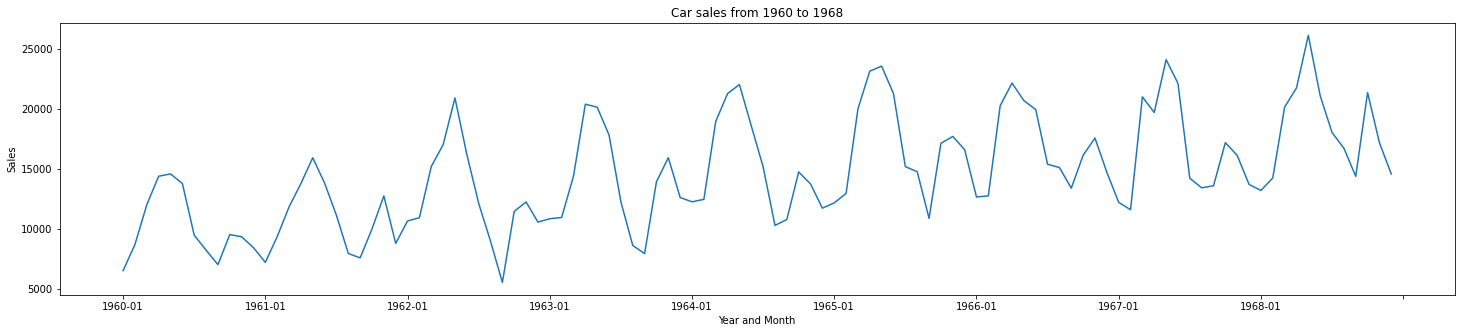

In [3]:
plt.figure(figsize=(25,5))
plt.plot(df.index, df.values)
plt.xticks(np.arange(0, len(df.index)+1, 12.0))
plt.title('Car sales from 1960 to 1968')
plt.ylabel('Sales')
plt.xlabel('Year and Month')
plt.show()

From the above plot we can infer two main aspects on the time series. The first one is that sales exhibit an overall positive trend over time, despite local fluctuations. Nonetheless, these fluctuations represent the second aspect, which is perhaps the most interesting one. We can see that there is a repeating yearly-pattern, with a big peak in the second quarter and a second smaller peak in the final quarter of each year. The peaks are intercepted by valleys, corresponding to a local sales minimum. We will inspect the plot for the sales of a single year to inspect this pattern in more detail:

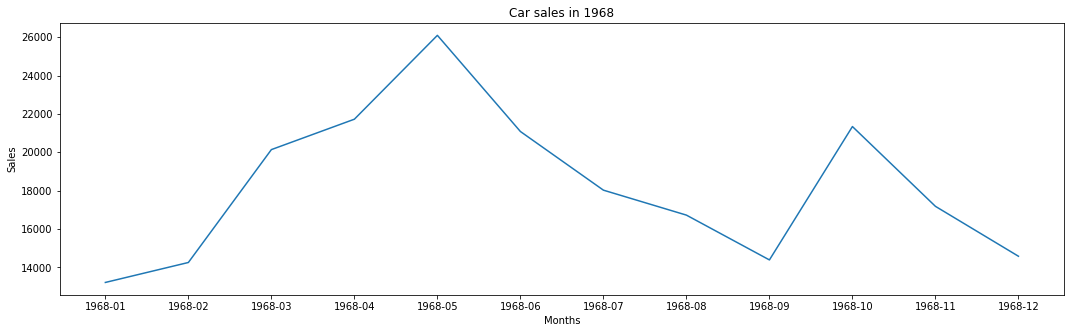

In [4]:
plt.figure(figsize=(18,5))
plt.plot(df.index[-12:], df.values[-12:])
plt.title('Car sales in 1968')
plt.ylabel('Sales')
plt.xlabel('Months')
plt.show()

Indeed, we observe the highest peak in May, and the smaller peak in October, with valleys in January and September. We were able to visually identify this pattern, but we need to train the RNN model with these data in order to produce accurate predictions. Nonetheless, before we advance to training the models, we will create some auxiliary functions and structures.

#### Creating functions and other support structures

We copied the `split_sequence` function from the reference tutorial, but made a small alteration to it, so we can specify the number of returned outputs as a parameter. Therefore, in practice, we can pass a sequence to be split or "windowed", with the number of values in each window corresponding to the `n_step` parameter and the number of predicted outputs corresponding to the `n_out` parameter. The original function assumed this value to be 1, but we will need to have 3 outputs in the last exercise, so we needed to adapt the function.

In [5]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, n_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_x = i + n_steps
        end_y = end_x + n_out

        # check if we are beyond the sequence
        if end_y > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_x], sequence[end_x:end_y]
        X.append(seq_x)
        y.append(seq_y)
    return np.asarray(X), np.asarray(y)

The `plot_metrics` function was designed to plot the metrics that are saved in the model's history (created during the model fit). We will be plotting the evolution of the mean absolute error (MAE) and loss (we will be using mean square error, or MSE) over the different epochs. Since these values will vary greatly in orders of magnitude in some of the exercises, we also defined this function to accept parameters to define the y-axis upper limit for each of these plots. We also created a `month_list` to assist with plotting the different months in the x-axis.

In [6]:
def plot_metrics (history, mae_lim = 35000, loss_lim=4000000000): 
    history_copy = history
    
    mae_hist = history_copy.history['mae']
    val_mae_hist = history_copy.history['val_mae']
    loss = history_copy.history['loss']
    val_loss = history_copy.history['val_loss']

    #we have defined the range this way instead of using the epochs, to deal with cases of early stopping
    epochs_range= range(len(mae_hist))

    plt.figure(figsize=(25, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, mae_hist, label='Training MAE')
    plt.plot(epochs_range, val_mae_hist, label='Validation MAE')
    plt.ylim(0,mae_lim)
    plt.ylabel('MAE')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    plt.title('Training and Validation MAE')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.ylim(0,loss_lim)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

In [7]:
month_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

The `plot_prediction function` was created to plot the model prediction on the test dataset, as well as the true sales values. The predictions will be represented with a red X and the true sales with a green line. We decided to keep one of the plots as a line so it would be easier to identify the pattern we observed previously. For simplicity, the function will use the last trained model to generate the predictions, meaning we must call it after training each model. We could have defined the function to accept a given model as parameter, but for this assignment that will not be necessary, since we will be evaluating each model in its respective section.

In [8]:
def plot_prediction(y_label = 'Sales'):
  pred = []
  
  #generating predictions for each X_test
  for x in X_test:
    row_t=x.reshape((1, n_steps, 1))
    y_pred = model.predict(row_t)[0]
    y_pred = y_pred.tolist()[0]
    pred.append(y_pred)

  #retrieving the y_test values (true sales values)
  y_real = y_test.copy()
  y_real = y_real.tolist()

  plt.figure(figsize=(7,4))
  plt.plot(month_list, y_real,'green', label='True sales')
  plt.plot(month_list, pred,'xr',label='Prediction')
  plt.title('Predicted car sales in 1968')
  plt.ylabel(y_label)
  plt.xlabel('Month')
  plt.legend()
  plt.show()

We will also be evaluating the performance of each model on the test data, using the MSE (which is our loss function), root mean square error (RMSE), and MAE. Since the RNN is initialized with random weights each time, the model will be different after each fit, which will also result in different values for these three metrics. Therefore, we will be running each model five times and register the mean and standard deviation of each metric. We will save these values in the `performance_metrics` dataframe, together with the exercise where we are running the model, as well as window and output sizes for that model.

In [9]:
performance_metrics = pd.DataFrame({'Model':[],
                                    'Window size':[],
                                    'Output size':[], 
                                    'Average MSE':[],
                                    'Std.Dev MSE':[],
                                    'Average RMSE':[],
                                    'Std.Dev RMSE':[],
                                    'Average MAE':[],
                                    'Std.Dev MAE':[]})

### 0. Tutorial example

We start by running the example in section 3.3 of the reference tutorial. Here, each window will be composed of five consecutive months and the output will be the next month in sequence. The data will only be separated into train and test, with the latter being composed of 12 windows (X_test) and their respective outputs (y_test). The test data will be used as both the validation set during model fit, as well as to compute the evaluation metrics. The remaining data will be used for training the model. We also constructed the model as it was defined in the tutorial (one LSTM and three Dense layers), including the compiling and fitting steps (the number of epochs is set at 350). However, we saved the model fit history along the epochs in a variable, so we could later use it to plot the evolution of MAE and loss.

In [10]:
# retrieve the values
values = df.values.astype('float32')
# specify the window size and output size
n_steps = 5
n_out = 1
# split into samples
X, y = split_sequence(values, n_steps, n_out)
# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
# split into train/test
n_test = 12
X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(91, 5, 1) (12, 5, 1) (91, 1) (12, 1)


As previously stated, we will be running the model five times and registering the average and standard deviation of each of the three evaluation metrics (MSE, RMSE, and MSE), due to the random initialization of weights in the RNN that will results in a different final model (and thus evaluation metrics) each time. We will be saving these values in the `performance_metrics` dataframe. We set the verbose=0 so the different epochs and their metrics are not displayed in the final notebook, reducing unnecessary clutter, although we verified these values during the development of the present assignment.

In [11]:
mse_list = []
rmse_list = []
mae_list = []

for i in range(5):  
  # define model
  model = Sequential()
  model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
  model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(1))
  # compile the model
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  # fit the model
  epochs=350
  history_0 = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0, validation_data=(X_test, y_test))
  # evaluate the model
  mse, mae = model.evaluate(X_test, y_test, verbose=0)
  rmse = np.sqrt(mse)
  print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, rmse, mae))
  
  mse_list.append(mse)
  rmse_list.append(rmse)
  mae_list.append(mae)

MSE: 13910489.000, RMSE: 3729.677, MAE: 2928.481
MSE: 13650616.000, RMSE: 3694.674, MAE: 3227.973
MSE: 13760707.000, RMSE: 3709.543, MAE: 2948.601
MSE: 11000677.000, RMSE: 3316.727, MAE: 2605.137
MSE: 8561123.000, RMSE: 2925.940, MAE: 2433.926


In [12]:
mse_mean = stats.mean(mse_list)
rmse_mean = stats.mean(rmse_list)
mae_mean = stats.mean(mae_list)

mse_std = stats.stdev(mse_list)
rmse_std = stats.stdev(rmse_list)
mae_std = stats.stdev(mae_list)

new_row = {'Model':'Exercise 0',
           'Window size': n_steps,
           'Output size': n_out, 
           'Average MSE':mse_mean, 
           'Std.Dev MSE':mse_std,
           'Average RMSE':rmse_mean, 
           'Std.Dev RMSE':rmse_std,
           'Average MAE':mae_mean, 
           'Std.Dev MAE':mae_std, 
           }

performance_metrics = performance_metrics.append(new_row, ignore_index=True)
performance_metrics

,Model,Window size,Output size,Average MSE,Std.Dev MSE,Average RMSE,Std.Dev RMSE,Average MAE,Std.Dev MAE
0,Exercise 0,5.0,1.0,12176722.4,2.352815e+06,3475.312005,351.654786,2828.82373,312.081276


In a first analysis we observe that the MSE (loss) has a mean value in the order of 1e7. This extremely high value is due to the fact that this loss function squares the errors, which prevents positive and negative errors from canceling each other, but as a result of squaring will greatly increase the error value. Furthermore, the fact that the sales data ranges approximately from 5000 to 25000 (range obtained by inspecting the first plot in the data loading section), will also result in the increase of these errors, when compared to data with narrower interval ranges and smaller absolute values (this will be dealt with in exercise 2). For the same reason, MAE and RMSE also present average values around 2600 and 3000, respectively.

Next, we will be plotting the MAE and Loss (MSE) metrics. Since we ran the model 5 times, we will only be displaying the plots for the last run inside the loop.


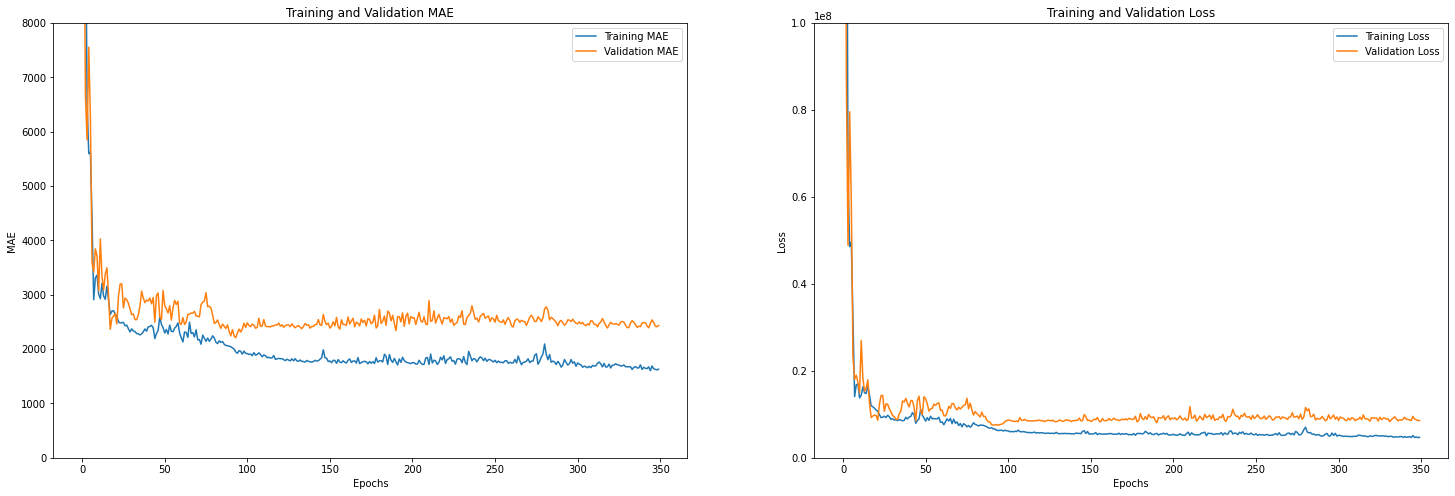

In [13]:
#plotting metrics
plot_metrics(history_0, mae_lim=8000, loss_lim=100000000)

MAE and Loss decreased sharply in the first 10 epochs (approximately), with the validation metrics (using the test portion of the dataset) staying somewhat consistent after the 100th epoch, despite small oscillations being observed. At the end of training, the validation MAE and MSE have values of, approximately, 2500 and 10000000.

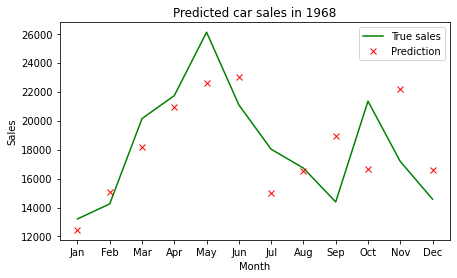

In [14]:
#plotting predictions
plot_prediction()

Just like with the performance metrics, we will be plotting the predictions generated from the last model only. We can see that overall the predicted and real sales values were not very different for most months, although some divergences occurred for the predictions of July and from September to November. In these months, the pattern that can be observed in the true sales could not be accurately predicted by the model.

The results of this model will be the reference for the models generated in the following exercises, which will hopefully constitute an improvement.


### 1. Use a 6 month training window and compare it with the reference model

In the first exercise we will increase the window size to include 6 months instead of 5, leaving all the other parameters unaltered. 

In [15]:
# retrieve the values
values = df.values.astype('float32')
# specify the window size and output size
n_steps = 6
n_out = 1
# split into samples
X, y = split_sequence(values, n_steps, n_out)
# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
# split into train/test
n_test = 12
X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(90, 6, 1) (12, 6, 1) (90, 1) (12, 1)


In [16]:
mse_list = []
rmse_list = []
mae_list = []

for i in range(5):  
  model = Sequential()
  model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
  model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(1))

  # compile the model
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  # fit the model
  epochs=350
  history_1 = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0, validation_data=(X_test, y_test))
  # evaluate the model
  mse, mae = model.evaluate(X_test, y_test, verbose=0)
  rmse = np.sqrt(mse)
  print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, rmse, mae))

  mse_list.append(mse)
  rmse_list.append(rmse)
  mae_list.append(mae)

MSE: 12497012.000, RMSE: 3535.111, MAE: 2923.050
MSE: 10291234.000, RMSE: 3207.995, MAE: 2846.176
MSE: 12856267.000, RMSE: 3585.564, MAE: 2932.989
MSE: 12412785.000, RMSE: 3523.178, MAE: 2938.123
MSE: 10419911.000, RMSE: 3227.989, MAE: 2558.604


In [17]:
mse_mean = stats.mean(mse_list)
rmse_mean = stats.mean(rmse_list)
mae_mean = stats.mean(mae_list)

mse_std = stats.stdev(mse_list)
rmse_std = stats.stdev(rmse_list)
mae_std = stats.stdev(mae_list)

new_row = {'Model':'Exercise 1',
           'Window size': n_steps,
           'Output size': n_out, 
           'Average MSE':mse_mean, 
           'Std.Dev MSE':mse_std,
           'Average RMSE':rmse_mean, 
           'Std.Dev RMSE':rmse_std,
           'Average MAE':mae_mean, 
           'Std.Dev MAE':mae_std, 
           }

performance_metrics = performance_metrics.append(new_row, ignore_index=True)
performance_metrics

,Model,Window size,Output size,Average MSE,Std.Dev MSE,Average RMSE,Std.Dev RMSE,Average MAE,Std.Dev MAE
0,Exercise 0,5.0,1.0,12176722.4,2.352815e+06,3475.312005,351.654786,2828.823730,312.081276
1,Exercise 1,6.0,1.0,11695441.8,1.235252e+06,3415.967455,182.373738,2839.788184,161.550353


Increasing the window size had little effect on the average of the different metrics, which were similar to the reference model (Exercise 0). Nonetheless, the standard deviation for each metrics appears to have decreased to approximately half the value of the reference model, implying the bigger window resulted in more constant models trained over the five runs.

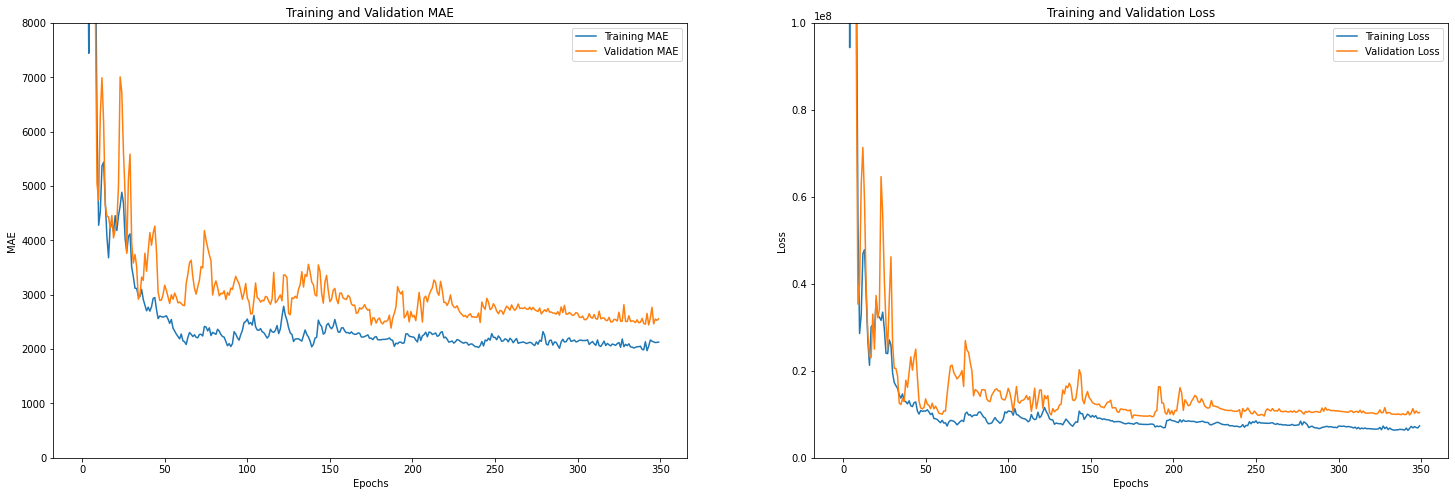

In [18]:
#plotting metrics
plot_metrics(history_1, mae_lim=8000, loss_lim=100000000)

The MAE and Loss values at the end of fit for the validation set were slightly higher than the reference model, at approximately 3000 and 15000000, respectively. Local stabilization of the MAE and loss only occurs after the 250th epoch. It is important to keep in mind that these plots are generated from the history of the last generated model in the five runs, and the model could behave differently if it were to be trained again.

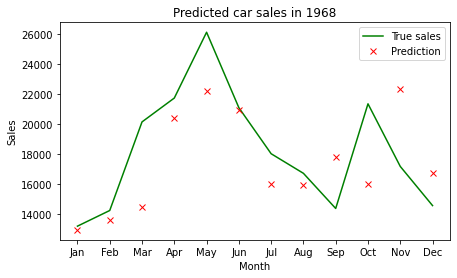

In [19]:
#plotting predictions
plot_prediction()

As for the prediction of the new model, it does not appear to perform better than the reference, as the months of March, May, and September through November display predictions that are significantly different than the true sales values. Once more, these are the predictions of the last trained model and different results would be obtained if any other of the five models were to generate the predictions. Nonetheless, given the relatively lower standard deviation of the metrics, this plot may be considered representative of the general predictive capabilities of the models in Exercise 1.

### 2. Improve the previous model and analyze the learning curves to check the model convergence

In this section we will improve the model by introducing some preprocessing of the data in the form of normalization, as well as adding batch normalization and dropout to the model. Data will also be split into train, validation, and test fractions. Furthermore, we will also increase the batch size, number of epochs and introduce early stopping to prevent overfitting. We explain these alterations in more detail as they appear.

First, we defined a new set of data to be extracted from the original dataset: the validation fraction. This fraction is going to be used to validate the model during fitting, while the testing data will remain unknown to the model until the evaluation step (to compute the three evaluation metrics), and will also be used to generate the predictions. This guarantees that the test data is not used in any way to train the model, thus providing a more correct evaluation approach. We defined both the validation and test data to contain 12 windows (and respective single y outputs) each. We tried following the example in the tensorflow tutorial, where the validation portion of the data was double the test portion (24 and 12 windows in our case), but this greatly reduced the performance of the model during training (higher MAE and loss), and thus we decided to keep both at 12.


In [20]:
# retrieve the values
values = df.values.astype('float32')
# specify the window size and output size
n_steps = 6
n_out = 1
# split into samples
X, y = split_sequence(values, n_steps, n_out)
# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
# split into train/test
n_val = 12
n_test = 12
X_train, X_val, X_test, y_train, y_val, y_test = X[:-(n_val + n_test)], X[-(n_val + n_test):-n_test], X[-n_test:], y[:-(n_val + n_test)], y[-(n_val + n_test):-n_test], y[-n_test:]
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(78, 6, 1) (12, 6, 1) (12, 6, 1) (78, 1) (12, 1) (12, 1)


Normalization of the data will greatly reduce their absolute values, which consequently will have a great impact on reducing the MAE and loss values, as it was discussed in Section 0. Apart from this relative alteration of values, by normalizing all data based on the mean and standard variation of the training data, we make sure that new data (e.g., test data) is properly scaled before making prediction. Furthermore, we make sure that the testing data is also compliant with the scale of the training data.

To execute the normalization process, we followed the strategy shown in the tensorflow tutorial. However, since this normalization procedure was performed before splitting (windowing) the data, we needed to compute the mean and standard deviation of the training data as it was in the original dataframe. To do so, we will fetch the sales values from the original dataframe, excluding the months that will solely be used for validation and training. We find this to be a better approach than simply using the already windowed data of the X_train, as it contains the repetition of values that are present in more than one window, which will have an impact on the mean and standard deviation. After calculating these values, we apply the normalization equally across the train, validation, and test datasets, both for X and y (since each y is data from the same univariate series).


In [21]:
X_train_unique = df[0:-(n_val+n_test)]
X_train_unique = np.array(X_train_unique)

train_mean = X_train_unique.mean()
train_std = X_train_unique.std()

X_train = (X_train - train_mean) / train_std
X_val = (X_val - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

y_train = (y_train - train_mean) / train_std
y_val = (y_val - train_mean) / train_std
y_test = (y_test - train_mean) / train_std

As for the model, we added BatchNormalization after between all the layers, and well as dropouts with a value of 0.4 (implying 40% of nodes will be randomly dropped during training). We found this was a good value to reduce overfitting, while also maintaining low metrics for loss and MAE. Other values such as 0.33 or even 0.5 worked well, but we found that 0.4 provided more consistent results between runs.
We also increased the number of epochs to 1000, as the loss curve exhibit a slightly decreasing behavior at the end of the 350 epochs. To avoid overfitting, we included the EarlyStopping callback, with a patience of 150 epochs and restore_best_weights=True. This way, if the loss does not increase over 150 epochs during training, the training stops and the weights revert back to their state 150 epochs before the stopping point. We decided to set patience as 150 since we often observed loss peaks that would subside after 100 epochs, and the loss curve would return to a decreasing state. We could have increased this number further to guarantee we would always get the lowest weights, but that would also require the increase of the number of epochs, to prevent training for finishing before the early stop patience window could be verified. It is important to note that when plotting the history, all the epochs until stopping will be show. If the last epoch shown is smaller than 1000, it means that early stopping stopped the model and the weights from 150 epochs back were used in the model. Otherwise, the model used all epochs to train.


In [22]:
mse_list = []
rmse_list = []
mae_list = []

for i in range(5):  
  # define model
  model = Sequential()
  model.add(BatchNormalization())
  model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(Dense(1))

  # compile the model
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])

  epochs=1000

  # configure early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', patience=150, restore_best_weights=True)

  # fit the model
  history_2 = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0, validation_data=(X_val, y_val),callbacks=[es])

  # evaluate the model
  mse, mae = model.evaluate(X_test, y_test, verbose=0)
  rmse = np.sqrt(mse)
  print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, rmse, mae))

  mse_list.append(mse)
  rmse_list.append(rmse)
  mae_list.append(mae)

MSE: 0.363, RMSE: 0.603, MAE: 0.461
MSE: 0.619, RMSE: 0.787, MAE: 0.599
MSE: 0.544, RMSE: 0.738, MAE: 0.575
MSE: 0.454, RMSE: 0.674, MAE: 0.499
MSE: 0.425, RMSE: 0.652, MAE: 0.489


In [23]:
mse_mean = stats.mean(mse_list)
rmse_mean = stats.mean(rmse_list)
mae_mean = stats.mean(mae_list)

mse_std = stats.stdev(mse_list)
rmse_std = stats.stdev(rmse_list)
mae_std = stats.stdev(mae_list)

new_row = {'Model':'Exercise 2',
           'Window size': n_steps,
           'Output size': n_out, 
           'Average MSE':mse_mean, 
           'Std.Dev MSE':mse_std,
           'Average RMSE':rmse_mean, 
           'Std.Dev RMSE':rmse_std,
           'Average MAE':mae_mean, 
           'Std.Dev MAE':mae_std, 
           }

performance_metrics = performance_metrics.append(new_row, ignore_index=True)
performance_metrics

,Model,Window size,Output size,Average MSE,Std.Dev MSE,Average RMSE,Std.Dev RMSE,Average MAE,Std.Dev MAE
0,Exercise 0,5.0,1.0,1.217672e+07,2.352815e+06,3475.312005,351.654786,2828.823730,312.081276
1,Exercise 1,6.0,1.0,1.169544e+07,1.235252e+06,3415.967455,182.373738,2839.788184,161.550353
2,Exercise 2,6.0,1.0,4.811373e-01,1.007612e-01,0.690622,0.072273,0.524675,0.059354


After performing the previously detailed alterations, we observe that all metric averages are now smaller than 1 (this also implies that the RMSE is now greater then the MSE). However, due to scaling, the metrics cannot be directly comparable to those of models generated in exercises 0 and 1.

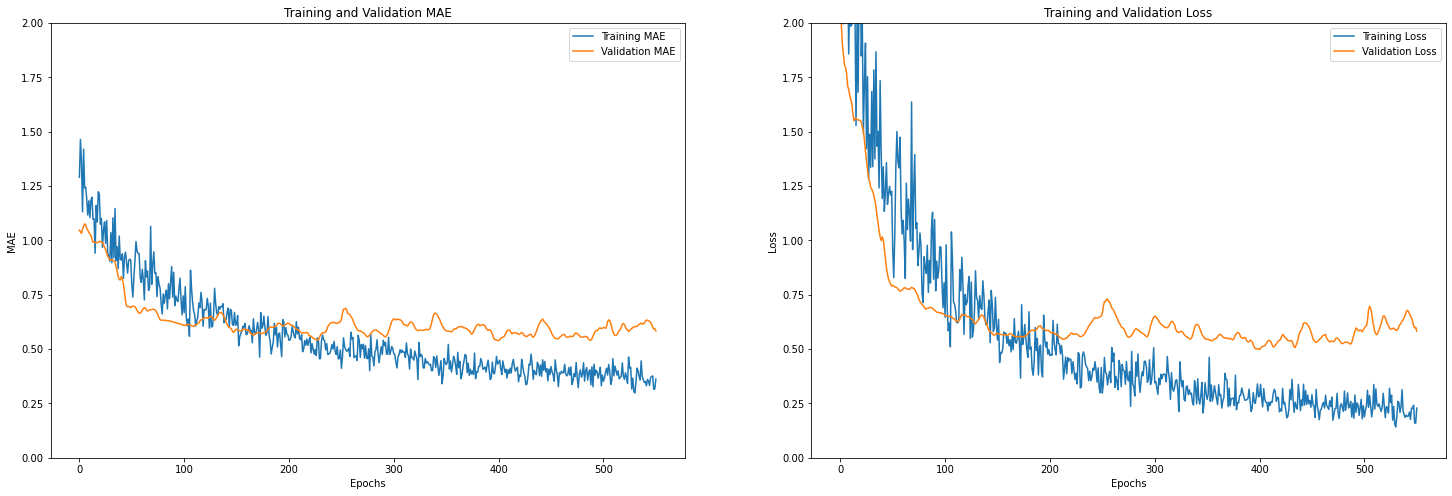

In [24]:
#plotting metrics
plot_metrics(history_2, mae_lim=2, loss_lim=2)

Looking at the MSE and RMSE plots, we can observe that there is no global increase in loss after a certain epoch, implying overfit has been greatly reduced, and loss is stabilizing in a local minimum. It is important to note that we performed several alterations on the previous model and chose the present configuration and parameters as those who were the most consistent. Nonetheless, the evaluation of these metrics is dependent on the scale, so we will also inspect the predictive capabilities of the model next.

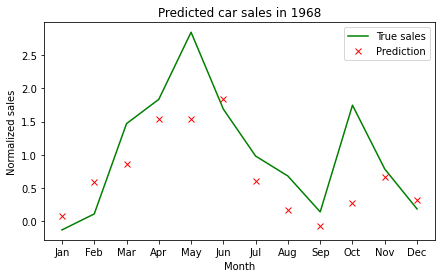

In [25]:
#plotting predictions
plot_prediction(y_label = 'Normalized sales')

This time the model's predictions were more accurate, as they start to capture the overall peaks and valleys pattern of car sales. However, the predicted values are still slightly different than the predictions for the May and October peaks. Nonetheless, this is already a significant improvement from the previous models.

### 3. Repeat the above experiment with a training window of 12 months.

In this exercise we will increase the training window to 12 months, instead of 6. This will allow the model to see a full year of sales as input before predicting the sales for the month that immediately follows that sequence. The construction of the model and parameterizations were set to be equal to those defined in the previous exercise.

In [26]:
# retrieve the values
values = df.values.astype('float32')
# specify the window size and output size
n_steps = 12
n_out = 1
# split into samples
X, y = split_sequence(values, n_steps, n_out)
# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
# split into train/test
n_val = 12
n_test = 12
X_train, X_val, X_test, y_train, y_val, y_test = X[:-(n_val + n_test)], X[-(n_val + n_test):-n_test], X[-n_test:], y[:-(n_val + n_test)], y[-(n_val + n_test):-n_test], y[-n_test:]
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(72, 12, 1) (12, 12, 1) (12, 12, 1) (72, 1) (12, 1) (12, 1)


In [27]:
X_train_unique = df[0:-(n_val+n_test)]
X_train_unique = np.array(X_train_unique)

train_mean = X_train_unique.mean()
train_std = X_train_unique.std()

X_train = (X_train - train_mean) / train_std
X_val = (X_val - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

y_train = (y_train - train_mean) / train_std
y_val = (y_val - train_mean) / train_std
y_test = (y_test - train_mean) / train_std

In [28]:
mse_list = []
rmse_list = []
mae_list = []

for i in range(5):  
  # define model
  model = Sequential()
  model.add(BatchNormalization())
  model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(Dense(1))

  # compile the model
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])

  epochs=1000

  # configure early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', patience=150, restore_best_weights=True)

  # fit the model
  history_3 = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0, validation_data=(X_val, y_val),callbacks=[es])

  # evaluate the model
  mse, mae = model.evaluate(X_test, y_test, verbose=0)
  rmse = np.sqrt(mse)
  print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, rmse, mae))

  mse_list.append(mse)
  rmse_list.append(rmse)
  mae_list.append(mae)

MSE: 0.269, RMSE: 0.518, MAE: 0.351
MSE: 0.322, RMSE: 0.567, MAE: 0.376
MSE: 0.412, RMSE: 0.642, MAE: 0.477
MSE: 0.297, RMSE: 0.545, MAE: 0.438
MSE: 0.226, RMSE: 0.475, MAE: 0.340


In [29]:
mse_mean = stats.mean(mse_list)
rmse_mean = stats.mean(rmse_list)
mae_mean = stats.mean(mae_list)

mse_std = stats.stdev(mse_list)
rmse_std = stats.stdev(rmse_list)
mae_std = stats.stdev(mae_list)

new_row = {'Model':'Exercise 3',
           'Window size': n_steps,
           'Output size': n_out, 
           'Average MSE':mse_mean, 
           'Std.Dev MSE':mse_std,
           'Average RMSE':rmse_mean, 
           'Std.Dev RMSE':rmse_std,
           'Average MAE':mae_mean, 
           'Std.Dev MAE':mae_std, 
           }

performance_metrics = performance_metrics.append(new_row, ignore_index=True)
performance_metrics

,Model,Window size,Output size,Average MSE,Std.Dev MSE,Average RMSE,Std.Dev RMSE,Average MAE,Std.Dev MAE
0,Exercise 0,5.0,1.0,1.217672e+07,2.352815e+06,3475.312005,351.654786,2828.823730,312.081276
1,Exercise 1,6.0,1.0,1.169544e+07,1.235252e+06,3415.967455,182.373738,2839.788184,161.550353
2,Exercise 2,6.0,1.0,4.811373e-01,1.007612e-01,0.690622,0.072273,0.524675,0.059354
3,Exercise 3,12.0,1.0,3.052647e-01,6.963818e-02,0.549720,0.061978,0.396562,0.058906


The metrics are still very similar to those of the previous exercise with respect to both the mean and standard deviation of RMSE and MAE. Average and standard deviation of MSE were reduced by a factor of 1.5 when compared to the previous model.

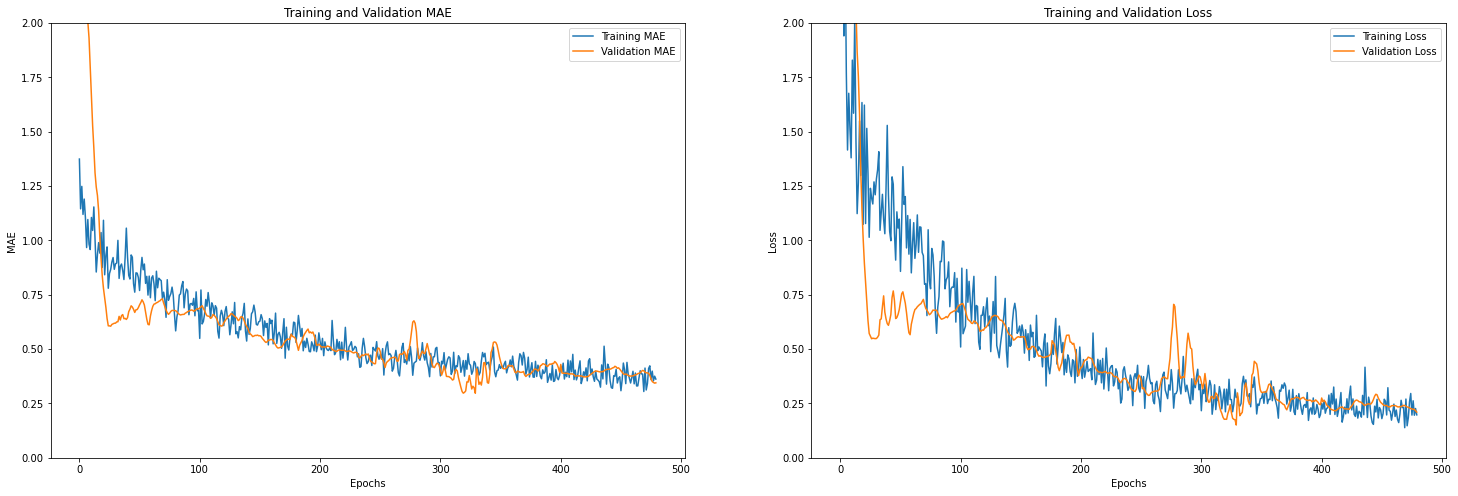

In [30]:
#plotting metrics
plot_metrics(history_3, mae_lim=2, loss_lim=2)

Inspecting the MAE and loss curves we continue to observe a decreasing behavior along the epochs, which closely follows the decrease of the same metrics for the training data. This implies overfit is minimal and the model is continually improving until its stopping point at around 320 epochs (early stopping saves the weights as they were 150 epochs before stopping).

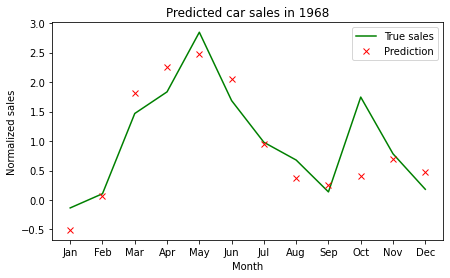

In [31]:
#plotting predictions
plot_prediction(y_label = 'Normalized sales')

This time we observe that the predictions were more accurate as a result of the increase of the window size to a full year. Only the October peak was not correctly predicted, but other than that all predictions were extremely close to the true sales value. Overall, this has proven to be the best model so far, even keeping in mind that we are only evaluating the last fitted model out of five training procedures.

### 4. Multi-step model with a 6 months training window and predict the next 3 months (in the future).

For the last exercise, we were required to predict the next 3 months following the input window of 6 months. Once again, we referred to the tensorflow tutorial. We started by executing the first steps similar to previous models, but this time we define the number of outputs (n_out) as 3, so our y arrays were composed of three values instead of only one.

In [32]:
# retrieve the values
values = df.values.astype('float32')
# specify the window size and output size
n_steps = 6
n_out = 3
# split into samples
X, y = split_sequence(values, n_steps, n_out)
# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
# split into train/test
n_val = 12
n_test = 12
X_train, X_val, X_test, y_train, y_val, y_test = X[:-(n_val + n_test)], X[-(n_val + n_test):-n_test], X[-n_test:], y[:-(n_val + n_test)], y[-(n_val + n_test):-n_test], y[-n_test:]
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(76, 6, 1) (12, 6, 1) (12, 6, 1) (76, 3) (12, 3) (12, 3)


In [33]:
X_train_unique = df[0:-(n_val+n_test)]
X_train_unique = np.array(X_train_unique)

train_mean = X_train_unique.mean()
train_std = X_train_unique.std()

X_train = (X_train - train_mean) / train_std
X_val = (X_val - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

y_train = (y_train - train_mean) / train_std
y_val = (y_val - train_mean) / train_std
y_test = (y_test - train_mean) / train_std

Following the instructions in the tutorial, we also defined the number of outputs of the last Dense layer of our model to be the same as our number of outputs, so we could train a single-shot model. Since this is a single-shot multi-step model, all three predictions are generated in a single step and there is no autoregression ocurring.

In [34]:
mse_list = []
rmse_list = []
mae_list = []

for i in range(5):  
  # define model
  model = Sequential()
  model.add(BatchNormalization())
  model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(Dense(n_out))

  # compile the model
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])

  epochs=1000

  # configure early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', patience=150, restore_best_weights=True)

  # fit the model
  history_4 = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0, validation_data=(X_val, y_val),callbacks=[es])

  # evaluate the model
  mse, mae = model.evaluate(X_test, y_test, verbose=0)
  rmse = np.sqrt(mse)
  print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, rmse, mae))

  mse_list.append(mse)
  rmse_list.append(rmse)
  mae_list.append(mae)

MSE: 0.428, RMSE: 0.655, MAE: 0.490
MSE: 0.434, RMSE: 0.658, MAE: 0.471
MSE: 0.495, RMSE: 0.704, MAE: 0.556
MSE: 0.577, RMSE: 0.759, MAE: 0.602
MSE: 0.601, RMSE: 0.775, MAE: 0.622


In [35]:
mse_mean = stats.mean(mse_list)
rmse_mean = stats.mean(rmse_list)
mae_mean = stats.mean(mae_list)

mse_std = stats.stdev(mse_list)
rmse_std = stats.stdev(rmse_list)
mae_std = stats.stdev(mae_list)

new_row = {'Model':'Exercise 4',
           'Window size': n_steps,
           'Output size': n_out, 
           'Average MSE':mse_mean, 
           'Std.Dev MSE':mse_std,
           'Average RMSE':rmse_mean, 
           'Std.Dev RMSE':rmse_std,
           'Average MAE':mae_mean, 
           'Std.Dev MAE':mae_std, 
           }

performance_metrics = performance_metrics.append(new_row, ignore_index=True)
performance_metrics

,Model,Window size,Output size,Average MSE,Std.Dev MSE,Average RMSE,Std.Dev RMSE,Average MAE,Std.Dev MAE
0,Exercise 0,5.0,1.0,1.217672e+07,2.352815e+06,3475.312005,351.654786,2828.823730,312.081276
1,Exercise 1,6.0,1.0,1.169544e+07,1.235252e+06,3415.967455,182.373738,2839.788184,161.550353
2,Exercise 2,6.0,1.0,4.811373e-01,1.007612e-01,0.690622,0.072273,0.524675,0.059354
3,Exercise 3,12.0,1.0,3.052647e-01,6.963818e-02,0.549720,0.061978,0.396562,0.058906
4,Exercise 4,6.0,3.0,5.070002e-01,7.968293e-02,0.710286,0.055830,0.548212,0.066635


The evaluation metrics increased from the last model, and are now very similar to the Exercise 2 model, which also used a window size of 6 months, although it only predicted 1 following month. This means than predicting two additional months did not affect the model performance significantly.

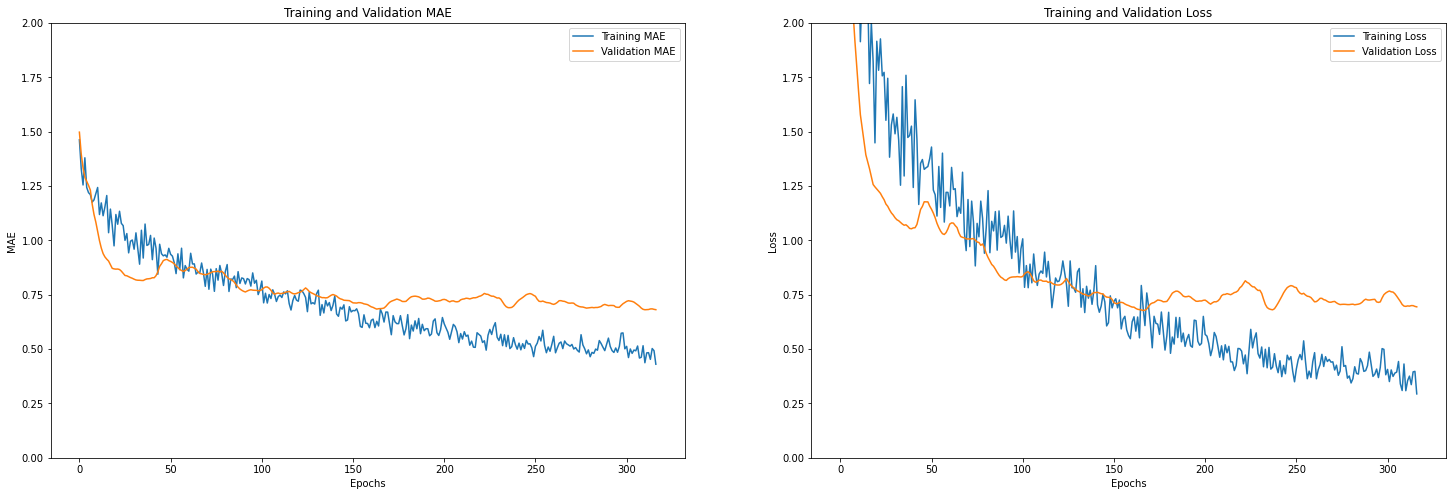

In [36]:
#plotting metrics
plot_metrics(history_4, mae_lim=2, loss_lim=2)

MAE and Loss curves also do not display overfitting (no overall increase in loss after a certain epoch) and the model appears to have converged in a local loss minimum.

So far, we have plotted our predictions using only one output per input window, so we could simply plot all the outputs of our test data against the true values, since we knew that each prediction was generated from the window immediately preceding that month. However, we are now generating three predictions, meaning some months will be predicted up to three times, by three different windows that precede it. For that reason, we will be generating a plot for each window, displaying this input window as a blue line, the true sales values as green dots and the predicted values as red X's.


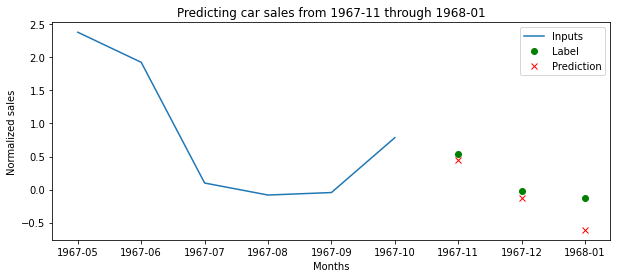

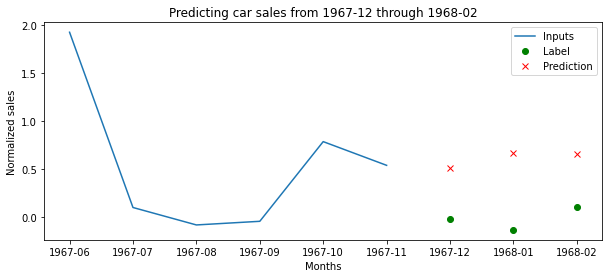

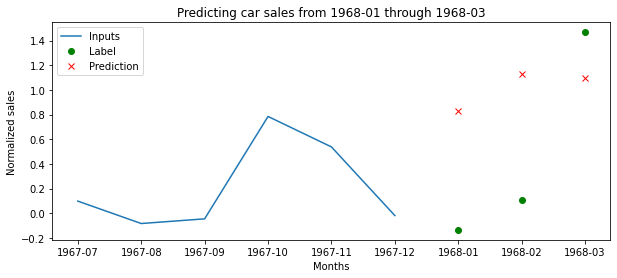

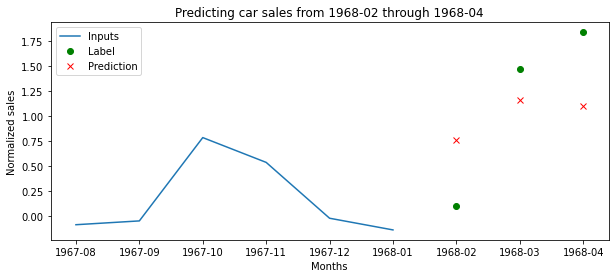

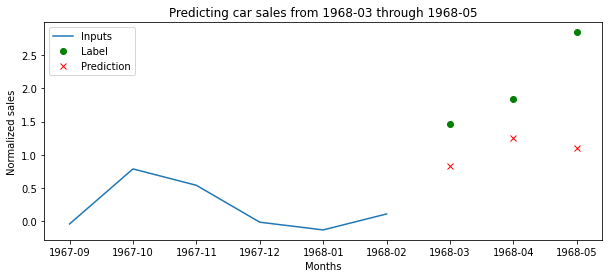

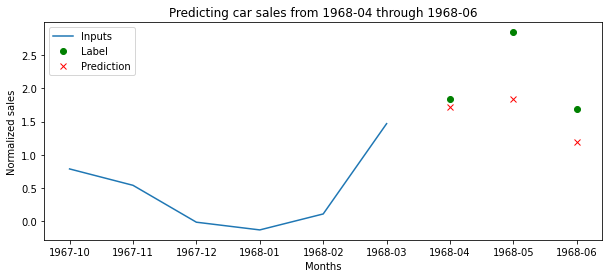

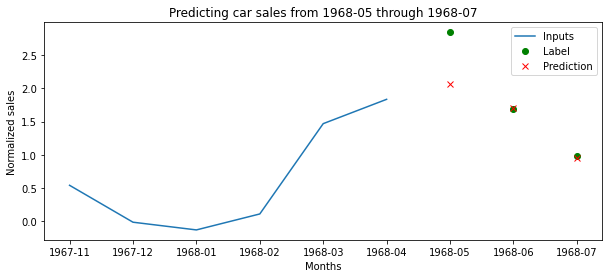

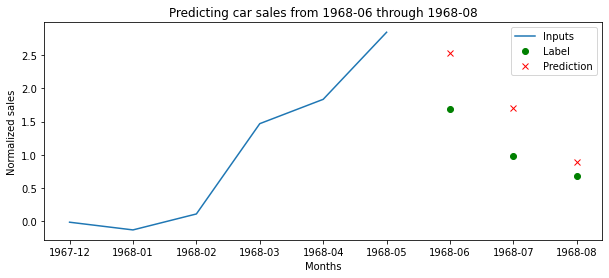

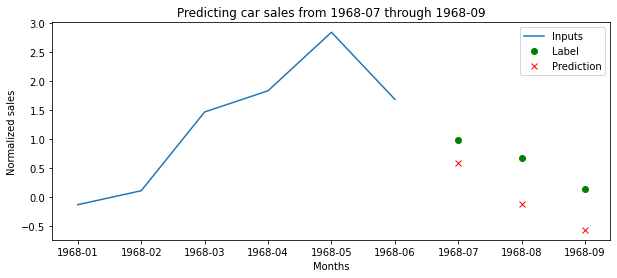

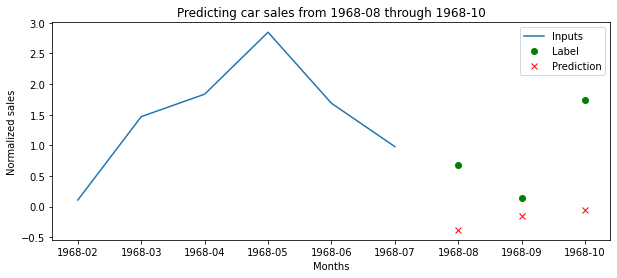

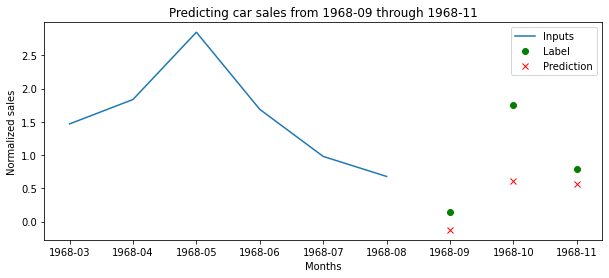

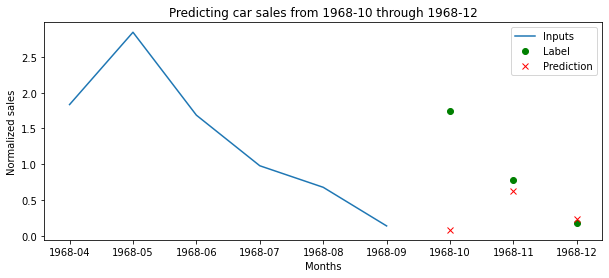

In [37]:
for i in np.arange(-12,0):
  row_t=X_test[i].reshape((1, n_steps, 1))
  row_t = row_t.tolist()
  pred = model.predict(row_t)
  pred = pred.tolist()[0]

  #after prediction we can transform row_t to a 2D array so it can be used in the plot
  row_t = row_t[0]

  if i != -1: #since the last index is exclusive, we can't have [idx:0] in the x_outupt, but rather [idx:]
    x_input = df.index[i-8: i-2]
    x_output = df.index[i-2 : i+1]
  else:
    x_input = df.index[i-8: i-2]
    x_output = df.index[i-2:]


  plt.figure(figsize=(10,4))
  plt.plot(x_input, row_t, label='Inputs')
  plt.plot(x_output, y_test[i],'og',label="Label")
  plt.plot(x_output, pred,'xr',label='Prediction')
  plt.legend()
  plt.ylabel('Normalized sales')
  plt.xlabel('Months')
  plt.title('Predicting car sales from {} through {}'.format(df.index[i-2],df.index[i]))
  plt.show()
  print() #spacer

An overall inspection of the plots evidences a variety of predictive capabilities of the model, with some inputs generating extremely accurate outputs, while others display predictions very different than the real value. The worst predictions ocurred for the months of January and February, when these were the first months to be predicted in the sequence (see plots 2 through 4). The May and October peaks were also poorly predicted regardless of their position in the output sequence. The peaks were also poorly predicted in Exercise 2, with a similar 6-month input windows. These two peaks appeared to be particularly challenging to predict for all models, with the exception of the model of Exercise 3, which correctly predicted the May's peak.

### Conclusions

Since the discussion of the performance of each of the models has already been addressed in each exercise, we will present a brief overview of our main conclusions. Overall, we observed that normalization of data and increase of window size had a positive effect on the performance of the models and their predictive capabilities. Particularly, when providing a whole year as input (exercise 3) we observed that the model performed exceptionally well in predicting sales. We also observed during experimentation with model construction that the inclusion of dropout was critical in reducing overfitting. Also, the increase of the number of epochs coupled with early stopping and best weight restorations allowed us to improve our model, by selecting the training epoch with minimal loss. We also found that by increasing the size of the validation set the models performed worse overall, which we attributed to the decrease of the size of the training set. If we were able to expand on the monthly sales data by including more years, we could increase the training and validation set sizes, which would hopefully lead to more robust results. Lastly, when predicting three months in a single-shot multi-step model we find that the results were similar to the predictions of a single month with the same 6-month input window, in terms of performance metrics. Despite observing some discrepancies between predicted and real values for the months of May and October, as well as for some January and February predictions, we were surprised that the model's overall performance was similar to that of the exercise 2 model, which only predicted a single month after the input sequence.